# Convolutional Neural Networks
Anastasia Ramig

## Introduction
Convolutional Neural Networks (CNNs) are a specialized type of neural network designed to process data structured in a grid, such as images. CNNs are commonly used in tasks like image recognition, object detection, and video analysis due to their ability to learn spatial hierarchies of features.

This notebook trains and validates a CNN on the Fashion MNIST dataset. This dataset contains images of pieces of clothing that can be classified as any of the following:
- 0: T-Shirt/Top
- 1: Trouser
- 2: Pullover
- 3: Dress
- 4: Coat
- 5: Sandal
- 6: Shirt
- 7: Sneaker
- 8: Bag
- 9: Ankle Boot

In [1]:
## Import necessary libraries
import pathlib
import time

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

**Note:** This notebook is set up to run on a GPU if there is one available. If not, it will run on a CPU.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Note:** The data in this notebook is run in Google Colab. The Fashion MNIST data files are accessed through Google Drive, which is mounted to the notebook in the cell below.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## Section 1: Baseline Model

The first section of this notebook builds a baseline model against which we can compare runtimes and accuracy for future models.The data is read in from CSV files and is split into a training and a testing set. From there, we further split the training set into a training and validation model. The data features consist of the individual pixels in the photo, and the data target is the label that corresponds to the type of clothing. A sample image is shown below.

In [5]:
# Set the filepaths for the training and testing data
train_data_filepath = pathlib.Path(r'/content/drive/MyDrive/data/fashion-mnist_train.csv')
test_data_filepath = pathlib.Path(r'/content/drive/MyDrive/data/fashion-mnist_test.csv')

## Read the data in as a polars DataFrame and split it into features and target data.
train_data = pl.read_csv(
    train_data_filepath
)

feature_ls = [col for col in train_data.columns if col!= 'label']
train_features = train_data.select(
    feature_ls
).with_columns(
    pl.all()/255.0
)

train_targets = train_data.select(
    'label'
).cast(
    pl.Int32
).to_dummies()

test_data = pl.read_csv(
    test_data_filepath
)

test_features = test_data.select(
    feature_ls
).with_columns(
    pl.all()/255.0
)

test_targets = test_data.select(
    'label'
).cast(
    pl.Int32
).to_dummies()

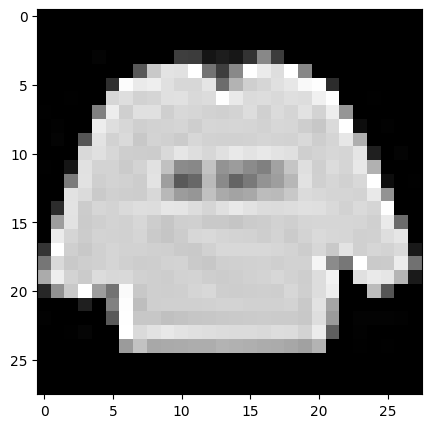

In [6]:
## Display a test image to help give an understanding of the dataset.
test_image = train_features[0].to_numpy().reshape(28, 28)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.imshow(
    test_image,
    cmap='gray',
    vmin=0,
    vmax=1
)

plt.show()

To build our convolutional neural network, we must first create a custom  class for our dataset.This allows us to use a Dataloader to batch the data and send it through the PyTorch model in smaller increments.

When the data is loaded, we must split it into the features and target sets. We one hot encode the target data and divide the feature data by 255 to convert all values to be between [0, 1]. From this loaded data, we use the MNISTDataset class that we create below to create PyTorch Dataset objects for each set.

In [7]:
## Define an MNISTDataset class to allow us to build our DataLoaders later on.
class MNISTDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image = self.features[idx].reshape(28, 28).astype('float32')
        label = self.targets[idx].astype('float32')
        return torch.tensor(image), torch.tensor(label)

In [8]:
# Set the filepaths for the training and testing data
train_data_filepath = pathlib.Path(r'/content/drive/MyDrive/data/fashion-mnist_train.csv')
test_data_filepath = pathlib.Path(r'/content/drive/MyDrive/data/fashion-mnist_test.csv')

## Read the data in as a polars DataFrame and split it into features and target data.
train_data = pl.read_csv(
    train_data_filepath
)

feature_ls = [col for col in train_data.columns if col!= 'label']
X_train_val = train_data.select(
    feature_ls
).with_columns(
    pl.all()/255.0
)
y_train_val = train_data.select(
    'label'
).cast(
    pl.Int32
).to_dummies()

X_train_val = X_train_val.to_numpy()
y_train_val = y_train_val.to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.08,
    random_state=42,
)


test_data = pl.read_csv(
    test_data_filepath
)
X_test = test_data.select(
    feature_ls
).with_columns(
    pl.all()/255.0
).to_numpy()
y_test = test_data.select(
    'label'
).cast(
    pl.Int32
).to_dummies().to_numpy()

## Use the MNISTDataset class to build PyTorch datasets for training, validation, and testing.
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)
test_dataset = MNISTDataset(X_test, y_test)

### Defining the Model

The simple CNN that we will use has the following structure:

Input Layer -> Conv1 Layer -> Relu -> Max Pooling 1 -> Conv2 Layer -> Relu -> Max Pooling 2 -> Flatten Layer -> FC1 -> Relu -> FC2 Layer

The layers are detailed below:
*   Convolutional Layers
  * These are the prominent distinguishing feature from other neural network architectures. The convolutional layers correspond to filters (kernels) slid across the input data to extract local features. Each filter detects different patterns, such as edges or textures.
* Pooling Layers
  * Pooling layers reduce the data's spatial dimensions (height and width) using techniques like max pooling or average pooling. Pooling reduces the number of parameters, reduces computational costs, and helps limit overfitting.
* Activation Functions
  * Activation functions, such as ReLU, are applied to introduce non-linearity into the model, allowing the network to learn more complex patterns.
* Fully Connected Layers
  * In a CNN, fully connected layers are applied near the network's end to combine features learned by the convolutional and pooling layers to make final predictions.

The initial parameters that we need to define for our model are the number of epochs, the batch size, and the learning rate. An epoch is a complete pass through of all the data through the CNN. After each epoch, the weights of the model can be adjusted to provide a better fit for the data. We will use 10 epochs for this example. The batch size dictates the number of images that are passed through the CNN at one time. The learning rate determines how much the model's weights are readjusted after each epoch.



In [24]:
## Define the model class for the CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        ## The out_channels is the number of features that we will experiment with later on.
        ## The kernel size is the filter size that we will experiment with later on.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.relufc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 64 * 5 * 5)
        x = self.fc1(x)
        x = self.relufc(x)
        x = self.fc2(x)
        return x

In [25]:
## Set the initial parameters for the baseline model.
num_epochs = 10
batch_size = 64
learning_rate = 0.001

In [26]:
## Build PyTorch DataLoaders using the training, validation, and testing PyTorch datasets.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

In [27]:
## Establish an instance of our CNN model
model = SimpleCNN()
model

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (relufc): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

The cell below trains the model on the train dataset and then validates it on our validation dataset. To understand the improvement of the CNN from epoch to epoch, we will track the training loss and the validation loss. The loss from each quantifies the difference between the model's predictions and the actual labels from either the training or validation set. The lower the loss, the better the model's performance. We will also keep track of the computational time to help us evaluate the performance of other hyperparameters during the experimentation portion.

In [28]:
## The to(device) instances in the cell below allow us to run the model on a GPU if there is one available
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

start_time = time.time()

## Train and validate the model for the set number of epochs.
training_history = []
for epoch in range(num_epochs):
    model.train()
    running_training_loss = 0.0
    for images, labels in train_loader:
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_training_loss += loss.item()

    training_loss = running_training_loss / len(train_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Training',
        'loss': training_loss
    })

    # Validation step
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.unsqueeze(1).to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    validation_loss = running_val_loss / len(val_loader)
    training_history.append({
        'epoch': epoch+1,
        'phase': 'Validation',
        'loss': validation_loss
    })

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

end_time = time.time()
baseline_elapsed_time = end_time - start_time
print(f' - Training for {num_epochs} epochs took {baseline_elapsed_time:.2f} seconds.')

Epoch [1/10], Training Loss: 0.5396, Validation Loss: 0.3862
Epoch [2/10], Training Loss: 0.3466, Validation Loss: 0.3070
Epoch [3/10], Training Loss: 0.2932, Validation Loss: 0.2823
Epoch [4/10], Training Loss: 0.2607, Validation Loss: 0.2799
Epoch [5/10], Training Loss: 0.2353, Validation Loss: 0.2567
Epoch [6/10], Training Loss: 0.2140, Validation Loss: 0.2457
Epoch [7/10], Training Loss: 0.1960, Validation Loss: 0.2548
Epoch [8/10], Training Loss: 0.1750, Validation Loss: 0.2324
Epoch [9/10], Training Loss: 0.1590, Validation Loss: 0.2461
Epoch [10/10], Training Loss: 0.1450, Validation Loss: 0.2483
 - Training for 10 epochs took 37.17 seconds.


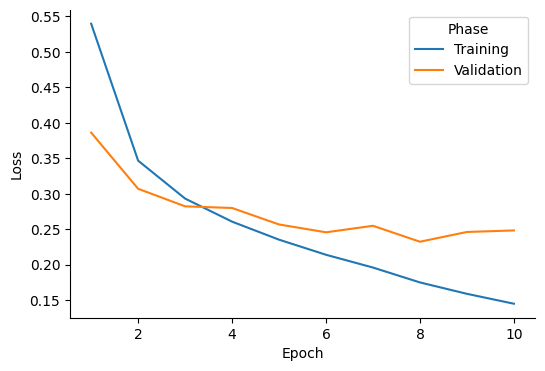

In [29]:
## Plot the training and validation losses to visualize the model's improvement over time.
training_history_df = pl.DataFrame(training_history)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

sns.lineplot(
    training_history_df,
    x='epoch',
    y='loss',
    hue='phase',
)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(title='Phase')
ax.spines[['right', 'top']].set_visible(False)

The final step to understanding the performance of our CNN is evaluating its accuracy on the test dataset.

In [30]:
## Evaluate the accuracy of the CNN model on the test dataset.
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.unsqueeze(1).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(axis=1)).sum().item()
baseline_accuracy = 100 * correct / total
print(f"Accuracy of the model on the test images: {baseline_accuracy:.2f}%")

Accuracy of the model on the test images: 91.58%


## Section 2: Experimentation

The next portion of this notebook will run an experiment that changes various hyperparameters of our CNN to observe their effects on computational time and predictive accuracy on the test set. The hyperparameters we will observe are:

* Filter Size
  * This dictates the size of the convolutional filters applied in the Conv1 and Conv2 layers. We will look at the results using a 3x3 and a 5x5 filter.
* Number of Features
  * This is the number of output channels in each convolutional layer. We will try to halve the number of features in the baseline model (16) and to double the number (64).
* Batch Size
  * This is the number of images that is passed through the CNN at one time. We will experiment with batch sizes of 32, 64, and 128.

Our first step in this portion is to define the building of the CNN as functions to allow us to easily change the filter size, number of features, and batch size.



In [17]:
def define_CNN(out_features, filter_size, pool2_out):
  class SimpleCNN(nn.Module):
      def __init__(self):
          super(SimpleCNN, self).__init__()
          self.conv1 = nn.Conv2d(in_channels=1, out_channels=out_features, kernel_size=filter_size)
          self.relu1 = nn.ReLU()
          self.pool1 = nn.MaxPool2d(2, 2)
          self.conv2 = nn.Conv2d(in_channels=out_features, out_channels=out_features * 2, kernel_size=filter_size)
          self.relu2 = nn.ReLU()
          self.pool2 = nn.MaxPool2d(2, 2)
          self.fc1 = nn.Linear(out_features * 2 * pool2_out * pool2_out, 128)
          self.relufc = nn.ReLU()
          self.fc2 = nn.Linear(128, 10)


      def forward(self, x):
          x = self.conv1(x)
          x = self.relu1(x)
          x = self.pool1(x)
          x = self.conv2(x)
          x = self.relu2(x)
          x = self.pool2(x)
          x = x.view(-1, out_features * 2 * pool2_out * pool2_out)
          x = self.fc1(x)
          x = self.relufc(x)
          x = self.fc2(x)
          return x
  return SimpleCNN()

In [18]:
def build_loaders(batch_size):
  train_loader = DataLoader(
      dataset=train_dataset,
      batch_size=batch_size,
      shuffle=True,
  )
  val_loader = DataLoader(
      dataset=val_dataset,
      batch_size=batch_size,
      shuffle=False,
  )
  test_loader = DataLoader(
      dataset=test_dataset,
      batch_size=batch_size,
      shuffle=False,
  )
  return train_loader, val_loader, test_loader

In [19]:
def train_val_model(model):
  model = model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  start_time = time.time()

  training_history = []
  for epoch in range(num_epochs):
      model.train()
      running_training_loss = 0.0
      for images, labels in train_loader:
          images = images.unsqueeze(1).to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          running_training_loss += loss.item()

      training_loss = running_training_loss / len(train_loader)
      training_history.append({
          'epoch': epoch+1,
          'phase': 'Training',
          'loss': training_loss
      })

      # Validation step
      model.eval()
      running_val_loss = 0.0
      with torch.no_grad():
          for images, labels in val_loader:
              images = images.unsqueeze(1).to(device)
              labels = labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)
              running_val_loss += loss.item()

      validation_loss = running_val_loss / len(val_loader)
      training_history.append({
          'epoch': epoch+1,
          'phase': 'Validation',
          'loss': validation_loss
      })

      print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {training_loss:.4f}, Validation Loss: {validation_loss:.4f}")

  end_time = time.time()
  elapsed_time = end_time - start_time
  return elapsed_time

In [20]:
def test_accuracy(model):
  model = model
  model = model.to(device)
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in test_loader:
          images = images.unsqueeze(1).to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels.argmax(axis=1)).sum().item()
  accuracy = 100 * correct / total
  return accuracy

To ensure that we test all possible combinations, we will use the product function of the Python itertools library. This will give us all combinations of the chosen filter size, number of features, and batch size.

In [21]:
import itertools
from itertools import product

filter_size_ls = [3, 5]
num_features_ls = [16, 64]
batch_size_ls = [32, 64, 128]

combinations = list(itertools.product(filter_size_ls, num_features_ls, batch_size_ls))
print(combinations)

[(3, 16, 32), (3, 16, 64), (3, 16, 128), (3, 64, 32), (3, 64, 64), (3, 64, 128), (5, 16, 32), (5, 16, 64), (5, 16, 128), (5, 64, 32), (5, 64, 64), (5, 64, 128)]


### Running the Experiment

To run the experiment, we will iterate through the list of combinations of filter size, number of features, and batch size.

The output size of the Max Pooling 2 layer output is based on the equation below.

$\displaystyle \mbox{Output Size}=\left\lfloor \frac{W−K+2P}{S} + 1\right\rfloor,$ where:

$W$ = input size (width/height),</br>
$K$ = kernel size,</br>
$P$ = padding,</br>
$S$ = stride.</br>

For our filter size of 3, the output should be 5x5x($2 * $number of features). For our filter size of 3, the output should be 4x4x($2 * $number of features).

The values of the hyperparameters (filter size, number of features, batch size), as well as the elapsed time and the accuracy of the model on test data, are saved into a dictionary for analysis.

In [22]:
experiment_results = {}
n = 1
for i in combinations:
  filter_size = i[0]
  num_features = i[1]
  batch_size = i[2]
  if filter_size == 3:
      pool2_out = 5
  if filter_size == 5:
      pool2_out = 4
  print(f'filter_size: {filter_size}, num_features: {num_features}, batch_size: {batch_size}')

  model = define_CNN(num_features, filter_size, pool2_out)
  train_loader, val_loader, test_loader = build_loaders(batch_size)
  elapsed_time = train_val_model(model)
  accuracy = test_accuracy(model)
  experiment_results[n] = {
      'filter_size': filter_size,
      'num_features': num_features,
      'batch_size': batch_size,
      'elapsed_time': elapsed_time,
      'accuracy': accuracy
  }
  n += 1

filter_size: 3, num_features: 16, batch_size: 32
Epoch [1/10], Training Loss: 0.5453, Validation Loss: 0.3743
Epoch [2/10], Training Loss: 0.3618, Validation Loss: 0.3438
Epoch [3/10], Training Loss: 0.3097, Validation Loss: 0.3185
Epoch [4/10], Training Loss: 0.2748, Validation Loss: 0.3294
Epoch [5/10], Training Loss: 0.2506, Validation Loss: 0.2673
Epoch [6/10], Training Loss: 0.2300, Validation Loss: 0.2590
Epoch [7/10], Training Loss: 0.2113, Validation Loss: 0.2520
Epoch [8/10], Training Loss: 0.1968, Validation Loss: 0.2589
Epoch [9/10], Training Loss: 0.1830, Validation Loss: 0.2580
Epoch [10/10], Training Loss: 0.1704, Validation Loss: 0.2774
filter_size: 3, num_features: 16, batch_size: 64
Epoch [1/10], Training Loss: 0.5883, Validation Loss: 0.4071
Epoch [2/10], Training Loss: 0.3882, Validation Loss: 0.3696
Epoch [3/10], Training Loss: 0.3341, Validation Loss: 0.3196
Epoch [4/10], Training Loss: 0.3012, Validation Loss: 0.3007
Epoch [5/10], Training Loss: 0.2773, Validation

## Section 3: Analysis

An initial look at the results of the experiment shows that the lowest computational time (27.8s) occurred for a filter size of 3, 16 features, and a batch size of 128. However, this model had the lowest accuracy of any model, including the baseline. The highest accuracy (92.09%) occurred when the filter size was 5, the number of features was 64, and the batch size was 128. This specific model had a runtime of 43.75s, which is only 6.58s faster than the baseline computational time of 37.17s. This model also presented a 0.51% increase in accuracy on the test model. Therefore, an initial analysis would suggest that the best hyperparameters for our simple CNN on the FashionMNIST Dataset are:
* Filter Size: 5
* Number of Features: 64
* Batch Size: 128

The effect of each hyperparameter on computational time and accuracy is below:
* Filter Size
  * Computational Time: Filter size does not appear to have a significant consistent effect on computational time.
  * Accuracy: Filter size does not appear to have a significant consistent effect on accuracy.
* Number of Features
  * Computational Time: Number of features does not appear to have a significant consistent effect on computational time.
  * Accuracy: A smaller number of features tends to reduce accuracy, while a larger number of features increases the accuracy of the model on the test data.
* Batch Size
  * Computational Time: Batch size appears to have the largest effect on computational time. The larger the batch size, the smaller the computational time.
  * Accuracy: For models with less features, a larger batch size tends to reduce the accuracy of the model on the test data. For models with a larger number of features, an increase in batch size is typically accompanied by an increase in accuracy. However, there are variations from this trend in the results of the experiment.

In [85]:
print(f'Baseline Accuracy: {baseline_accuracy:.2f}%')
print(f'Baseline Computational Time: {baseline_elapsed_time:.2f}')

Baseline Accuracy: 91.58%
Baseline Computational Time: 37.17


In [100]:
import pandas as pd
df = pd.DataFrame(experiment_results).T
df = pl.from_pandas(df)
df = df.with_columns(
    pl.col('elapsed_time').round(2).alias('elapsed_time'),
    pl.col('accuracy').round(2).alias('accuracy'),
    (pl.col('elapsed_time') - baseline_elapsed_time).round(2).alias('Difference from Baseline - Time'),
    (pl.col('accuracy') - baseline_accuracy).round(2).alias('Difference from Baseline - Accuracy')
)
pdf = df.to_pandas()
pdf

,filter_size,num_features,batch_size,elapsed_time,accuracy,Difference from Baseline - Time,Difference from Baseline - Accuracy
0,3.0,16.0,32.0,57.09,90.97,19.92,-0.61
1,3.0,16.0,64.0,36.62,90.87,-0.55,-0.71
2,3.0,16.0,128.0,27.77,89.67,-9.40,-1.91
3,3.0,64.0,32.0,56.27,91.84,19.10,0.26
4,3.0,64.0,64.0,41.44,92.01,4.27,0.43
5,3.0,64.0,128.0,35.96,92.03,-1.21,0.45
6,5.0,16.0,32.0,63.61,90.71,26.44,-0.87
7,5.0,16.0,64.0,40.38,90.95,3.21,-0.63
8,5.0,16.0,128.0,28.32,90.67,-8.85,-0.91
9,5.0,64.0,32.0,65.63,92.04,28.46,0.46


We can further analyze the effect of each hyperparameter on both computational time and accuracy, first by examining the mean and standard deviation of each when grouped according to hyperparameter value.

In [79]:
filter_size_df = df.group_by(
    'filter_size'
).agg([
    pl.col('elapsed_time').mean().alias('Average Elapsed Time'),
    pl.col('accuracy').mean().alias('Average Accuracy'),
    pl.col('elapsed_time').std().alias('Standard Deviation - Elapsed Time'),
    pl.col('accuracy').std().alias('Standard Deviation - Accuracy'),
])

num_features_df = df.group_by(
    'num_features'
).agg([
    pl.col('elapsed_time').mean().alias('Average Elapsed Time'),
    pl.col('accuracy').mean().alias('Average Accuracy'),
    pl.col('elapsed_time').std().alias('Standard Deviation - Elapsed Time'),
    pl.col('accuracy').std().alias('Standard Deviation - Accuracy'),
])

batch_size_df = df.group_by(
    'batch_size'
).agg([
    pl.col('elapsed_time').mean().alias('Average Elapsed Time'),
    pl.col('accuracy').mean().alias('Average Accuracy'),
    pl.col('elapsed_time').std().alias('Standard Deviation - Elapsed Time'),
    pl.col('accuracy').std().alias('Standard Deviation - Accuracy'),
])

Overall, there does not appear to be a large difference between the computational time and accuracy for filter sizes of 3 and 5.

In [80]:
filter_size_df

filter_size,Average Elapsed Time,Average Accuracy,Standard Deviation - Elapsed Time,Standard Deviation - Accuracy
f64,f64,f64,f64,f64
5.0,48.365189,91.421667,14.264501,0.713202
3.0,42.525001,91.231667,11.814134,0.922094


From the analysis below, there is a large improvement in average accuracy with a small standard deviation when the number of features is 64 rather than 16.

In [81]:
num_features_df

num_features,Average Elapsed Time,Average Accuracy,Standard Deviation - Elapsed Time,Standard Deviation - Accuracy
f64,f64,f64,f64,f64
64.0,48.591835,92.013333,10.80187,0.089592
16.0,42.298354,90.64,14.935504,0.490836


The best average computational time by far occurs when the batch size is 128, but this does come with a higher standard deviation than batch sizes of 32 and 64. The difference in the average accuracy between batch sizes is negligible, however, the standard deviation is much higher for a batch size of 128.

In [82]:
batch_size_df

batch_size,Average Elapsed Time,Average Accuracy,Standard Deviation - Elapsed Time,Standard Deviation - Accuracy
f64,f64,f64,f64,f64
64.0,41.73369,91.475,4.958218,0.653682
128.0,33.951398,91.115,7.529287,1.165318
32.0,60.650195,91.39,4.670874,0.649051


Another way that we can observe the effects of the hyperparameters on the performance of the CNN is by evaluating side by side boxplots for computational time and accuracy. From these, it appears that the number of features has the largest effect on accuracy and the batch size has the largest effect on computational time.

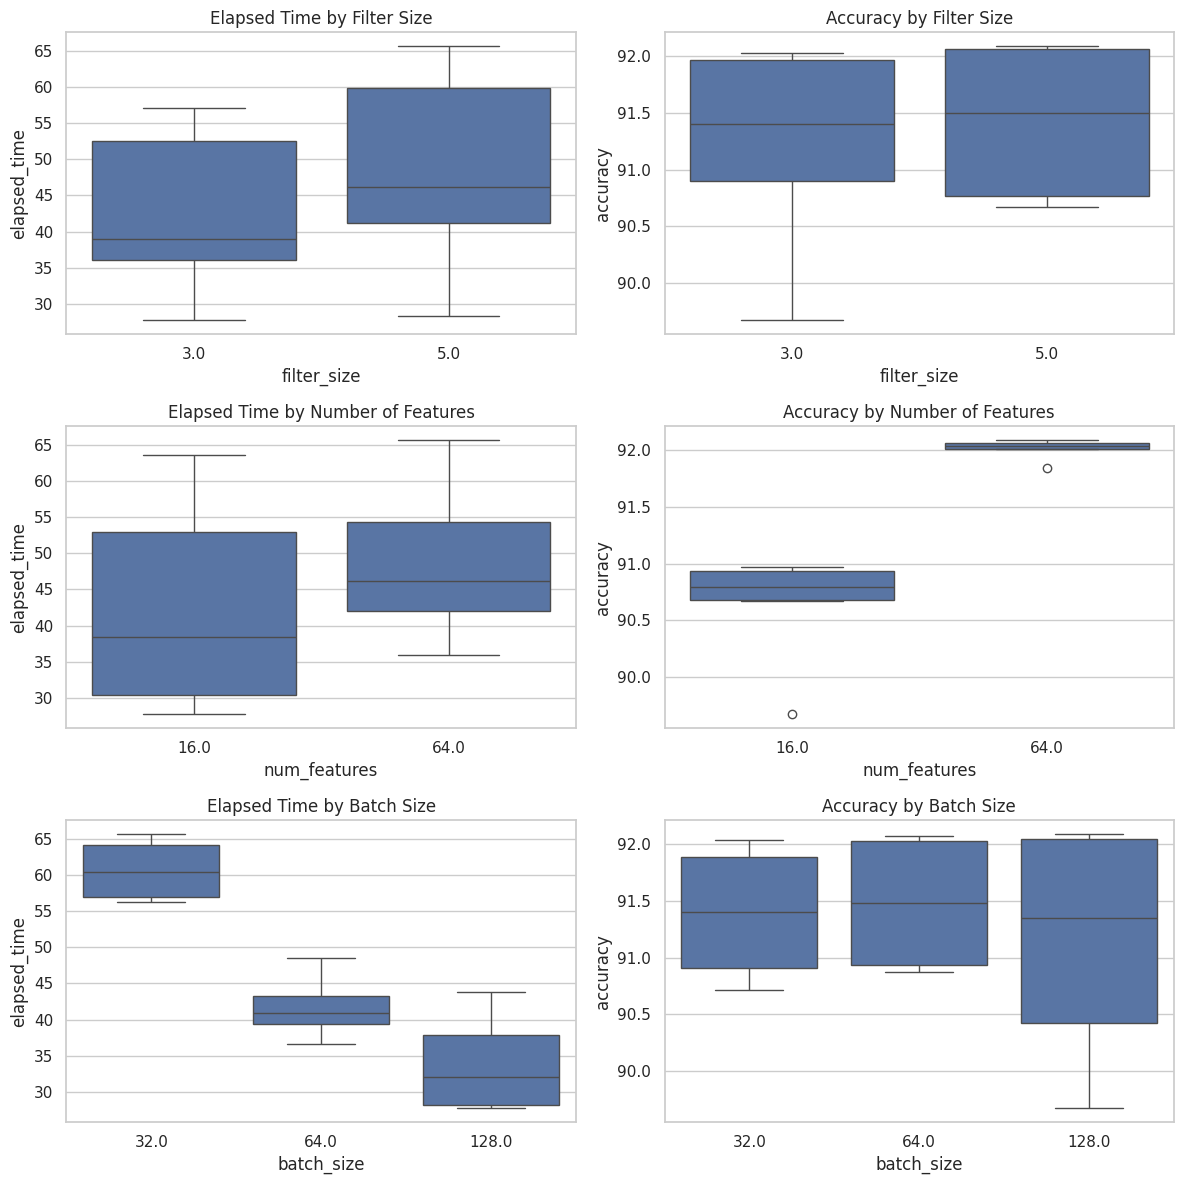

In [48]:
sns.set(style="whitegrid")
fig, axs = plt.subplots(3, 2, figsize=(12, 12))


sns.boxplot(x='filter_size', y='elapsed_time', data=df, ax=axs[0, 0])
axs[0, 0].set_title('Elapsed Time by Filter Size')

sns.boxplot(x='filter_size', y='accuracy', data=df, ax=axs[0, 1])
axs[0, 1].set_title('Accuracy by Filter Size')

sns.boxplot(x='num_features', y='elapsed_time', data=df, ax=axs[1, 0])
axs[1, 0].set_title('Elapsed Time by Number of Features')

sns.boxplot(x='num_features', y='accuracy', data=df, ax=axs[1, 1])
axs[1, 1].set_title('Accuracy by Number of Features')

sns.boxplot(x='batch_size', y='elapsed_time', data=df, ax=axs[2, 0])
axs[2, 0].set_title('Elapsed Time by Batch Size')

sns.boxplot(x='batch_size', y='accuracy', data=df, ax=axs[2, 1])
axs[2, 1].set_title('Accuracy by Batch Size')

plt.tight_layout()
plt.show()